# Capstone Project - The Battle of Neighborhoods

### Introduction

Toronto is the provincial capital of Ontario. With a recorded population of 2,731,571 in 2016, it is the most populous city in Canada. Toronto is an international center of business, finance, arts, and culture, and is recognized as one of the most multicultural and cosmopolitan cities in the world. The diverse population of Toronto reflects its current and historical role as an important destination for immigrants to Canada. More than 50 percent of residents belong to a visible minority population group, and over 200 distinct ethnic origins are represented among its inhabitants. While the majority of Torontonians speak English as their primary language, over 160 languages are spoken in the city.

Toronto is a prominent center for music, theatre, motion picture production, and television production, and is home to the headquarters of Canada's major national broadcast networks and media outlets. Its economy is highly diversified with strengths in technology, design, financial services, life sciences, education, arts, fashion, aerospace, environmental innovation, food services, and tourism.

Toronto is one of Canada's leading tourism destinations. In 2017, the Toronto-area received 43.7 million tourists, of which 10.4 million were domestic visitors and 2.97 million were from the United States, spending a total of $8.84 billion. Toronto has an array of tourist attractions, and a rich cultural life. Tourists always try to find a nice stay in any city. So as part of this project , we will list and visualize all major parts of Toronto City that has great Hotels.

### Data 
For this project we need the following data :
<ul>
<li> Toronto City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
    <ul>
        <li>Data source 1: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
        <li>Data source 2: http://cocl.us/Geospatial_data
        <li> Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of Toronto city.
     </ul>
<li> Hotels in each neighborhood of Toronto city.
        <ul>
        <li>Data source : Foursquare API
        <li> Description : By using this api we will get all the venues in each neighborhood. We can filter these venues to get only Hotels.
     </ul>

### Approach
- Collect the Toronto city data from Data Source 1 & 2
- Using FourSquare API we will find all venues for each neighborhood.
- Filter out all venues that are Hotels.
- Find rating, tips and like count for each Hotel using FourSquare API.
- Using rating for each Hotel, we will sort that data.
- Visualize the Ranking of neighborhoods using folium library(python)

### Questions that can be asked using the above mentioned datasets
- What is best location in Toronto City for Hotel Stay ? 
- Which areas have potential Hotel Market ? 
- Which all areas lack Hotels ?
- Which is the best place to stay if I prefer nice Hotel Stay ?

### Analysis

We will import the required libraries for python.

- pandas and numpy for handling data.
- request module for using FourSquare API.
- geopy to get co-ordinates of City of Toronto City.
- folium to visualize the results on a map

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="explore_toronto")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given  latitude and longitude. Below function will return us the venue id , venue name and category.

In [3]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'your Foursquare ID' # your Foursquare ID
    CLIENT_SECRET = 'your Foursquare Secret' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    venue_data = requests.get(url).json()["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df
    

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id.
This will be used for ranking.

In [30]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'your Foursquare ID' # your Foursquare ID
    CLIENT_SECRET = 'your Foursquare Secret' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    venue_data=requests.get(url).json()["response"]['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we extract the Toronto city data such as Boroughs, Neighborhoods.

In [5]:
# send the GET request
data = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(data, 'html.parser')
# create three lists to store table data
postalCodeList = []
boroughList = []
neighborhoodList = []
# append the data into the respective lists
for row in soup.find('table').find_all('tr'):
    cells = row.find_all('td')
    if(len(cells) > 0):
        postalCodeList.append(cells[0].text.strip())
        boroughList.append(cells[1].text.strip())
        neighborhoodList.append(cells[2].text.strip())
# create a new DataFrame from the three lists
toronto_df = pd.DataFrame({"PostalCode": postalCodeList,
                           "Borough": boroughList,
                           "Neighborhood": neighborhoodList})

# drop cells with a borough that is Not assigned
toronto_df_dropna = toronto_df[toronto_df.Borough != "Not assigned"].reset_index(drop=True)
# group neighborhoods in the same borough
toronto_df_grouped = toronto_df_dropna.groupby(["PostalCode", "Borough"], as_index=False).agg(lambda x: ", ".join(x))
# for Neighborhood="Not assigned", make the value the same as Borough
for index, row in toronto_df_grouped.iterrows():
    if row["Neighborhood"] == "Not assigned":
        row["Neighborhood"] = row["Borough"]

Extract lat and long data for each borough and neighborhood and merge with existing data frame

In [6]:
#GEo-code of each postal code
geo_df=pd.read_csv('http://cocl.us/Geospatial_data')
geo_df.rename(columns={'Postal Code':'PostalCode'},inplace=True)
geo_merged = pd.merge(geo_df, toronto_df_grouped, on='PostalCode')
toronto_df_new = geo_merged[['Borough','Neighborhood','Latitude','Longitude']]
toronto_df_new.shape

(103, 4)

In [7]:
toronto_df_new.head()

,Borough,Neighborhood,Latitude,Longitude
0,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,Scarborough,Woburn,43.770992,-79.216917
4,Scarborough,Cedarbrae,43.773136,-79.239476


So there are total of 103 different Neighborhoods in Toronto City

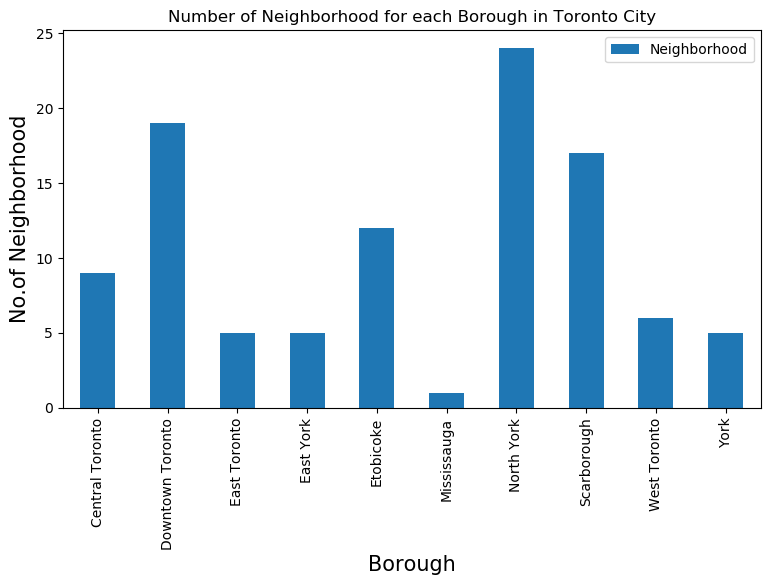

In [8]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in Toronto City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
toronto_df_new.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that North York has highest number of neighborhoods

Now we will collect Hotels for each Neighborhood

In [12]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
Hotel_torr = pd.DataFrame(columns=column_names)
count=1
for row in toronto_df_new.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    Hotels =venues[venues['Category']=='Hotel']   
    #print('(',count,'/',len(toronto_df_new),')','Hotels in '+Neighborhood+', '+Borough+':'+str(len(Hotels)))
    for Hotel_detail in Hotels.values.tolist():
        id, name , category=Hotel_detail
        Hotel_torr = Hotel_torr.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1
Hotel_torr

,Borough,Neighborhood,ID,Name
0,North York,"Willowdale, Willowdale East",4f9735ace4b0dc878e2b5633,Maryam Hotel
1,North York,"Willowdale, Willowdale East",4b2835dff964a520f09024e3,Novotel Toronto North York
2,North York,Downsview,524f17d9498e873f51833c6d,Best Western Plus Toronto North York Hotel & S...
3,North York,Downsview,4bcf611e0ffdce72b769b2c0,Holiday Inn Express Toronto-North York
4,North York,Downsview,4bd1a64b5e0cce72b9c7a184,Travelodge Norfinch Drive Hotel Toronto
5,North York,Downsview,4bc87946dc55eee1177ce8ac,Comfort Inn
6,East Toronto,Studio District,596186fd772fbc1671dff18b,The Broadview Hotel
7,Central Toronto,Davisville North,4b7810c3f964a52030b42ee3,Best Western Roehampton Hotel & Suites
8,Central Toronto,"North Toronto West, Lawrence Park",4dbadb240cb691071c7b4ce8,Glengrove Suites
9,Central Toronto,Davisville,4b7810c3f964a52030b42ee3,Best Western Roehampton Hotel & Suites


In [26]:
# Saving this dataframe to .csv in order to extract it later on in case we mistakely change the existing one
Hotel_torr.to_csv("Hotels.csv")
# considering random 50 samples from the generated dataframe, as the FourSquare API has daily limit on the premium API calls
Hotel_torr = Hotel_torr.sample(n=50)
Hotel_torr = Hotel_torr.reset_index(drop=True)
Hotel_torr

,Borough,Neighborhood,ID,Name
0,Downtown Toronto,Berczy Park,53357710498e20817350cfb4,Delta Hotels by Marriott Toronto
1,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",53357710498e20817350cfb4,Delta Hotels by Marriott Toronto
2,Downtown Toronto,"First Canadian Place, Underground city",53357710498e20817350cfb4,Delta Hotels by Marriott Toronto
3,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",4cb87a334c60a093c04a39ca,Le Germain Hotel
4,West Toronto,"Little Portugal, Trinity",4ad4c05cf964a520c0f520e3,Gladstone Hotel
5,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",4d2ce8d1fd2e236a8ac8ebde,The Ritz-Carlton
6,Downtown Toronto,"Richmond, Adelaide, King",4adf7d0bf964a520127b21e3,The Omni King Edward Hotel
7,Downtown Toronto,"Richmond, Adelaide, King",4e31b74252b131dcebb08743,Shangri-La Toronto
8,Downtown Toronto,St. James Town,4b7d9098f964a52014c72fe3,The Grand Hotel & Suites Toronto
9,Downtown Toronto,"Commerce Court, Victoria Hotel",4e31b74252b131dcebb08743,Shangri-La Toronto


Now that we have got all the Hotels in Toronto city , we will analyze it

We got 50 Hotels across Toronto City

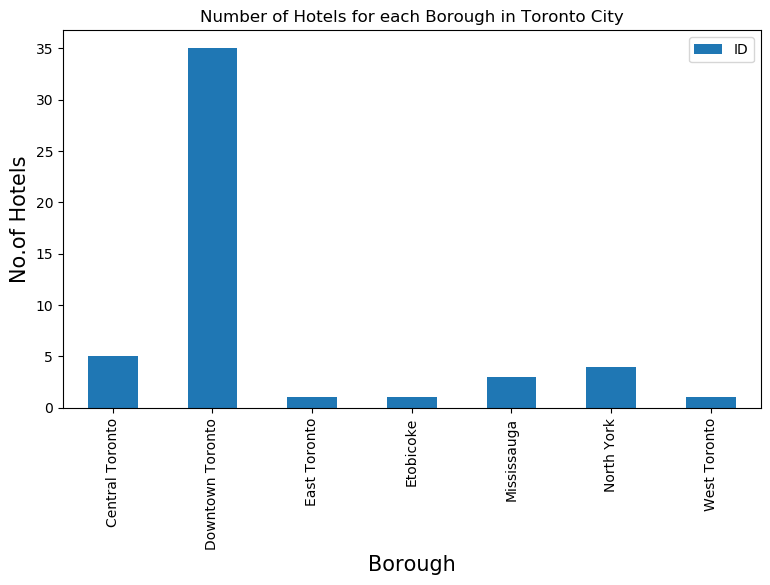

In [27]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Hotels for each Borough in Toronto City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Hotels', fontsize=15)
#giving a bar plot
Hotel_torr.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Downtown Toronto has the largest number of Hotels

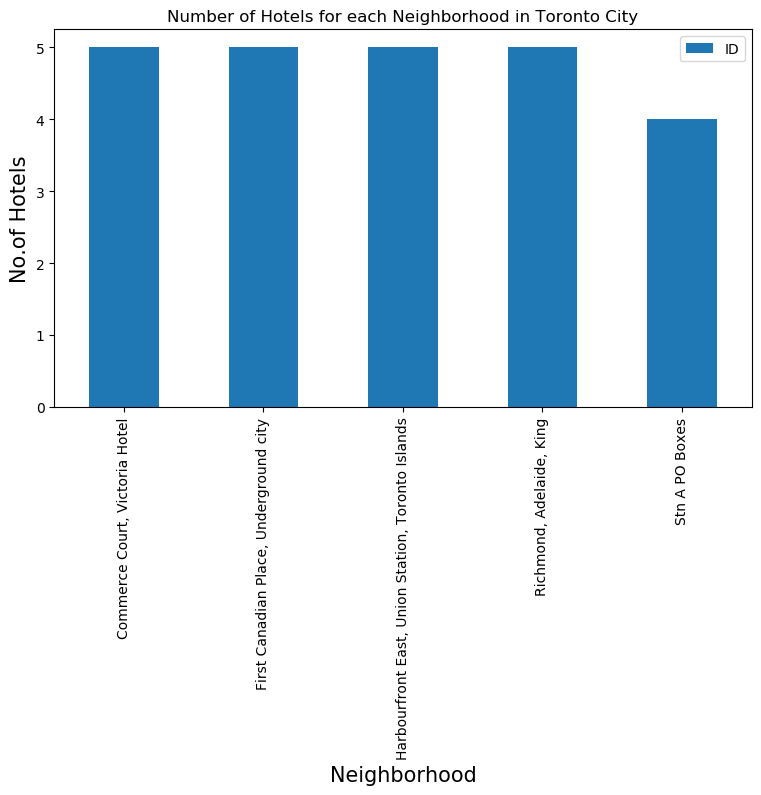

In [28]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Hotels for each Neighborhood in Toronto City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Hotels', fontsize=15)
#giving a bar plot
Hotel_torr.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that four neighborhoods have same number of Hotels

Now we will get the ranking of each Hotel for further analysis.

In [31]:
# prepare neighborhood list that contains Hotels
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
Hotels_stats=pd.DataFrame(columns=column_names)
count=1


for row in Hotel_torr.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these Hotels as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(Hotel_torr),')','processed')
    Hotels_stats = Hotels_stats.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                              Name  Likes  Rating  \
0  53357710498e20817350cfb4  Delta Hotels by Marriott Toronto    153     9.2   

   Tips  
0    16  
( 1 / 50 ) processed
                         ID                              Name  Likes  Rating  \
0  53357710498e20817350cfb4  Delta Hotels by Marriott Toronto    153     9.2   

   Tips  
0    16  
( 2 / 50 ) processed
                         ID                              Name  Likes  Rating  \
0  53357710498e20817350cfb4  Delta Hotels by Marriott Toronto    153     9.2   

   Tips  
0    16  
( 3 / 50 ) processed
                         ID              Name  Likes  Rating  Tips
0  4cb87a334c60a093c04a39ca  Le Germain Hotel     59     8.3    19
( 4 / 50 ) processed
                         ID             Name  Likes  Rating  Tips
0  4ad4c05cf964a520c0f520e3  Gladstone Hotel    174     8.2    75
( 5 / 50 ) processed
                         ID              Name  Likes  Rating  Tips
0  4d2ce8d1fd2e236a

                         ID                        Name  Likes  Rating  Tips
0  4adf7d0bf964a520127b21e3  The Omni King Edward Hotel    124     8.4    47
( 48 / 50 ) processed
                         ID  \
0  524f17d9498e873f51833c6d   

                                                Name  Likes  Rating  Tips  
0  Best Western Plus Toronto North York Hotel & S...     14     7.2     3  
( 49 / 50 ) processed
                         ID                              Name  Likes  Rating  \
0  53357710498e20817350cfb4  Delta Hotels by Marriott Toronto    153     9.2   

   Tips  
0    16  
( 50 / 50 ) processed


In [32]:
Hotels_stats

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Downtown Toronto,Berczy Park,53357710498e20817350cfb4,Delta Hotels by Marriott Toronto,153,9.2,16
1,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",53357710498e20817350cfb4,Delta Hotels by Marriott Toronto,153,9.2,16
2,Downtown Toronto,"First Canadian Place, Underground city",53357710498e20817350cfb4,Delta Hotels by Marriott Toronto,153,9.2,16
3,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",4cb87a334c60a093c04a39ca,Le Germain Hotel,59,8.3,19
4,West Toronto,"Little Portugal, Trinity",4ad4c05cf964a520c0f520e3,Gladstone Hotel,174,8.2,75
5,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",4d2ce8d1fd2e236a8ac8ebde,The Ritz-Carlton,184,8.5,56
6,Downtown Toronto,"Richmond, Adelaide, King",4adf7d0bf964a520127b21e3,The Omni King Edward Hotel,124,8.4,47
7,Downtown Toronto,"Richmond, Adelaide, King",4e31b74252b131dcebb08743,Shangri-La Toronto,181,8.3,47
8,Downtown Toronto,St. James Town,4b7d9098f964a52014c72fe3,The Grand Hotel & Suites Toronto,68,8.6,23
9,Downtown Toronto,"Commerce Court, Victoria Hotel",4e31b74252b131dcebb08743,Shangri-La Toronto,181,8.3,47


In [38]:
# Dropping those rows in which no ratings are present
Hotels_stats = Hotels_stats.drop(Hotels_stats[(Hotels_stats.ID == 0)].index)
Hotels_stats = Hotels_stats.reset_index(drop=True)
Hotels_stats

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Downtown Toronto,Berczy Park,53357710498e20817350cfb4,Delta Hotels by Marriott Toronto,153,9.2,16
1,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",53357710498e20817350cfb4,Delta Hotels by Marriott Toronto,153,9.2,16
2,Downtown Toronto,"First Canadian Place, Underground city",53357710498e20817350cfb4,Delta Hotels by Marriott Toronto,153,9.2,16
3,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",4cb87a334c60a093c04a39ca,Le Germain Hotel,59,8.3,19
4,West Toronto,"Little Portugal, Trinity",4ad4c05cf964a520c0f520e3,Gladstone Hotel,174,8.2,75
5,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",4d2ce8d1fd2e236a8ac8ebde,The Ritz-Carlton,184,8.5,56
6,Downtown Toronto,"Richmond, Adelaide, King",4adf7d0bf964a520127b21e3,The Omni King Edward Hotel,124,8.4,47
7,Downtown Toronto,"Richmond, Adelaide, King",4e31b74252b131dcebb08743,Shangri-La Toronto,181,8.3,47
8,Downtown Toronto,St. James Town,4b7d9098f964a52014c72fe3,The Grand Hotel & Suites Toronto,68,8.6,23
9,Downtown Toronto,"Commerce Court, Victoria Hotel",4e31b74252b131dcebb08743,Shangri-La Toronto,181,8.3,47


So we got data for all Hotels
Now lets save this data to a csv sheet. In case we by mistake modify it.
As the number of calls to get details for venue are premium call and have limited day, we will refer to saved data sheet csv if required

In [39]:
Hotels_stats.to_csv('Hotels_stats.csv', index=False)

Lets verify the data from saved csv file

In [40]:
Hotels_stats_csv=pd.read_csv('Hotels_stats.csv')

In [41]:
Hotels_stats_csv.shape

(48, 7)

In [42]:
Hotels_stats_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Downtown Toronto,Berczy Park,53357710498e20817350cfb4,Delta Hotels by Marriott Toronto,153,9.2,16
1,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",53357710498e20817350cfb4,Delta Hotels by Marriott Toronto,153,9.2,16
2,Downtown Toronto,"First Canadian Place, Underground city",53357710498e20817350cfb4,Delta Hotels by Marriott Toronto,153,9.2,16
3,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",4cb87a334c60a093c04a39ca,Le Germain Hotel,59,8.3,19
4,West Toronto,"Little Portugal, Trinity",4ad4c05cf964a520c0f520e3,Gladstone Hotel,174,8.2,75


In [43]:
Hotels_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       48 non-null     object 
 1   Neighborhood  48 non-null     object 
 2   ID            48 non-null     object 
 3   Name          48 non-null     object 
 4   Likes         48 non-null     object 
 5   Rating        48 non-null     float64
 6   Tips          48 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.8+ KB


We see that values like Likes, Tips are strig values. We would need to convert them into float for further analysis

In [44]:
Hotels_stats['Likes']=Hotels_stats['Likes'].astype('float64')

In [45]:
Hotels_stats['Tips']=Hotels_stats['Tips'].astype('float64')

In [46]:
Hotels_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       48 non-null     object 
 1   Neighborhood  48 non-null     object 
 2   ID            48 non-null     object 
 3   Name          48 non-null     object 
 4   Likes         48 non-null     float64
 5   Rating        48 non-null     float64
 6   Tips          48 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.8+ KB


Now the data types looks correct

In [47]:
# Hotels with maximum Likes
Hotels_stats.iloc[Hotels_stats['Likes'].idxmax()]

Borough                               Downtown Toronto
Neighborhood    First Canadian Place, Underground city
ID                            4ad4c05bf964a520a7f520e3
Name                           The Fairmont Royal York
Likes                                              395
Rating                                             8.3
Tips                                               117
Name: 14, dtype: object

In [48]:
# Hotels with maximum Rating
Hotels_stats.iloc[Hotels_stats['Rating'].idxmax()]

Borough                         Downtown Toronto
Neighborhood                         Berczy Park
ID                      53357710498e20817350cfb4
Name            Delta Hotels by Marriott Toronto
Likes                                        153
Rating                                       9.2
Tips                                          16
Name: 0, dtype: object

In [49]:
# Hotels with maximum Tips
Hotels_stats.iloc[Hotels_stats['Tips'].idxmax()]

Borough                               Downtown Toronto
Neighborhood    First Canadian Place, Underground city
ID                            4ad4c05bf964a520a7f520e3
Name                           The Fairmont Royal York
Likes                                              395
Rating                                             8.3
Tips                                               117
Name: 14, dtype: object

Now lets visualize neighborhood with maximum average rating of Hotels

In [105]:
Toronto_neighborhood_stats=Hotels_stats.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
Toronto_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [106]:
Toronto_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
15,Studio District,9.00
13,St. James Town,8.60
9,"Garden District, Ryerson",8.60
18,"Toronto Dominion Centre, Design Exchange",8.55
14,Stn A PO Boxes,8.55
8,"First Canadian Place, Underground city",8.54
4,"Commerce Court, Victoria Hotel",8.36
0,Berczy Park,8.30
3,Church and Wellesley,8.30
12,"Richmond, Adelaide, King",8.26


Above are the top neighborhoods with top average rating of Hotels

In [94]:
Toronto_borough_stats=Hotels_stats.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
Toronto_borough_stats.columns=['Borough','Average Rating']

In [95]:
Toronto_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,East Toronto,9.000000
1,Downtown Toronto,8.377143
5,West Toronto,8.200000
0,Central Toronto,7.025000
3,Mississauga,6.933333


Similarly these are the average rating of Hotels for each Borough

Lets visualize it

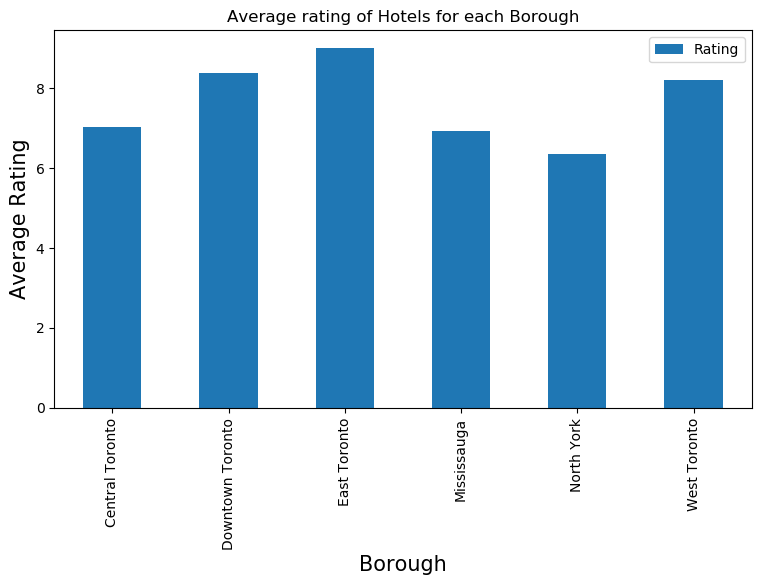

In [54]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Hotels for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
Hotels_stats.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 7.0 to visualize on map

In [63]:
Toronto_neighborhood_stats=Toronto_neighborhood_stats[Toronto_neighborhood_stats['Average Rating']>=7.0]

In [64]:
Toronto_neighborhood_stats

,Neighborhood,Average Rating
0,Berczy Park,8.30
2,Central Bay Street,7.80
3,Church and Wellesley,8.30
4,"Commerce Court, Victoria Hotel",8.36
8,"First Canadian Place, Underground city",8.54
9,"Garden District, Ryerson",8.60
10,"Harbourfront East, Union Station, Toronto Islands",8.16
11,"Little Portugal, Trinity",8.20
12,"Richmond, Adelaide, King",8.26
13,St. James Town,8.60


We will join this dataset to original Toronto City data to get lonitude and latitude

In [65]:
Toronto_neighborhood_stats=pd.merge(Toronto_neighborhood_stats,toronto_df_new, on='Neighborhood')

In [66]:
Toronto_neighborhood_stats=Toronto_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [67]:
Toronto_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Downtown Toronto,Berczy Park,43.644771,-79.373306,8.30
1,Downtown Toronto,Central Bay Street,43.657952,-79.387383,7.80
2,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,8.30
3,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,8.36
4,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,8.54
5,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,8.60
6,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,8.16
7,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,8.20
8,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,8.26
9,Downtown Toronto,St. James Town,43.651494,-79.375418,8.60


Now we will show this data on a map

In [68]:
# create map and display it
tor_map = folium.Map(location=geo_location('Toronto'), zoom_start=12)

In [69]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

for lat, lng, in Toronto_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )


Lets add a new field to dataframe for labeling purpose

In [70]:
Toronto_neighborhood_stats['Label']=Toronto_neighborhood_stats['Neighborhood']+', '+Toronto_neighborhood_stats['Borough']+'('+Toronto_neighborhood_stats['Average Rating'].map(str)+')'

In [71]:
# add pop-up text to each marker on the map
for lat, lng, label in Toronto_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(tor_map)        
# add incidents to map
tor_map.add_child(incidents)

Now that we have visualized the Neighborhoods.
<br>Lets Visualize Boroughs based on average Rating

In [96]:
Toronto_borough_stats=pd.merge(Toronto_borough_stats,toronto_df_new, on='Borough')
Toronto_borough_stats=Toronto_borough_stats[['Borough','Latitude','Longitude','Average Rating']]
Toronto_borough_stats

,Borough,Latitude,Longitude,Average Rating
0,Central Toronto,43.728020,-79.388790,7.025000
1,Central Toronto,43.712751,-79.390197,7.025000
2,Central Toronto,43.715383,-79.405678,7.025000
3,Central Toronto,43.704324,-79.388790,7.025000
4,Central Toronto,43.689574,-79.383160,7.025000
5,Central Toronto,43.686412,-79.400049,7.025000
6,Central Toronto,43.711695,-79.416936,7.025000
7,Central Toronto,43.696948,-79.411307,7.025000
8,Central Toronto,43.672710,-79.405678,7.025000
9,Downtown Toronto,43.679563,-79.377529,8.377143


In [99]:
Toronto_borough_stats.sort_values("Average Rating", inplace = True) 
  
# dropping ALL duplicte values 
Toronto_borough_stats.drop_duplicates(subset ="Average Rating", 
                     keep = "first", inplace = True) 
  
# displaying data 
Toronto_borough_stats

,Borough,Latitude,Longitude,Average Rating
52,North York,43.733283,-79.419750,6.350000
33,Mississauga,43.636966,-79.615819,6.933333
3,Central Toronto,43.704324,-79.388790,7.025000
61,West Toronto,43.661608,-79.464763,8.200000
16,Downtown Toronto,43.657952,-79.387383,8.377143
29,East Toronto,43.679557,-79.352188,9.000000


In [102]:
# create map and display it
tor_map = folium.Map(location=geo_location('Toronto'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

for lat, lng, in Toronto_borough_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
Toronto_borough_stats['Label']= Toronto_borough_stats['Borough']+'('+Toronto_borough_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in Toronto_borough_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(tor_map)        
# add incidents to map
tor_map.add_child(incidents)
tor_map.save('Toronto_borough_Hotel_rating.html')

**The saved image can be downloaded at** : https://github.com/themynkbnsl/Coursera_Capstone/blob/master/Toronto_borough_Hotel_rating.html

### Conclusion 
- Studio District(East Toronto), St. James Town(Downtown toronto), are some of the best neighborhoods for Hotel Stay. 
- Downtown Toronto have potential Hotel Market. 
- Willowdale, Willowdale East ranks last in average rating of Hotels.
- Downtown Toronto is the best place to stay if you prefer Variety of nice Hotel Stays.

### Limitations 
- The ranking is purely on basis of rating of Hotels
- The accuracy of data depends purely depends on the data provided by FourSquare